In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

temp_rain_soil = pd.read_csv("../../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:00:00,14.0,0.0,37.51600,10.400
2018-07-07 12:00:00,15.0,0.0,37.52375,10.600
2018-07-07 13:00:00,16.0,0.0,37.57200,10.700
2018-07-07 14:00:00,16.0,0.0,37.34300,10.725
2018-07-07 15:00:00,16.0,0.0,37.35050,10.950


In [ ]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90
2023-08-23 03:00:00,11.0,0.0,50.85500,11.65
2023-08-23 04:00:00,10.0,0.0,50.95325,11.60


In [ ]:
# Resample to daily mean values
temp_rain_soil_daily = temp_rain_soil.resample('D').mean()

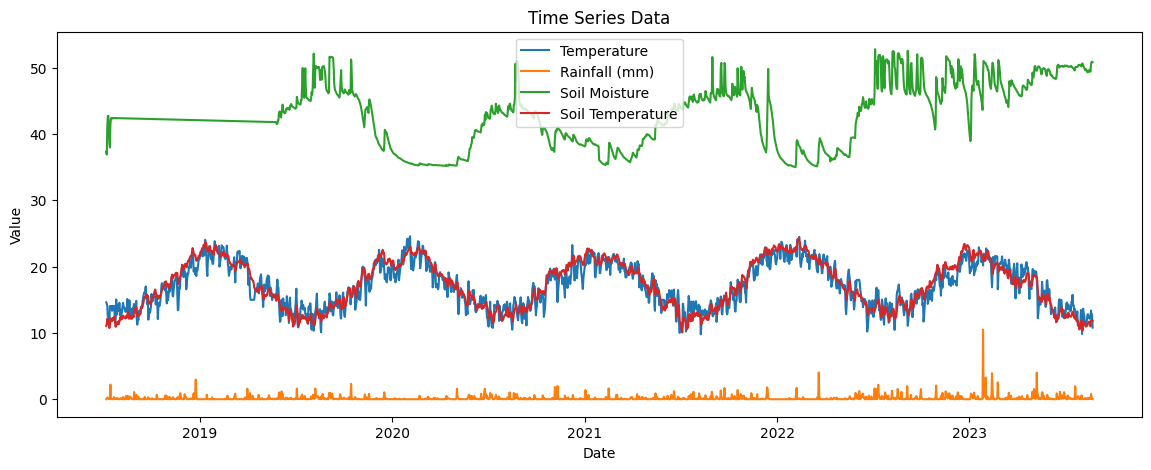

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(temp_rain_soil_daily['Temp'], label='Temperature')
plt.plot(temp_rain_soil_daily['Rain(mm)'], label='Rainfall (mm)')
plt.plot(temp_rain_soil_daily['SoilMoist'], label='Soil Moisture')
plt.plot(temp_rain_soil_daily['SoilTemp'], label='Soil Temperature')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

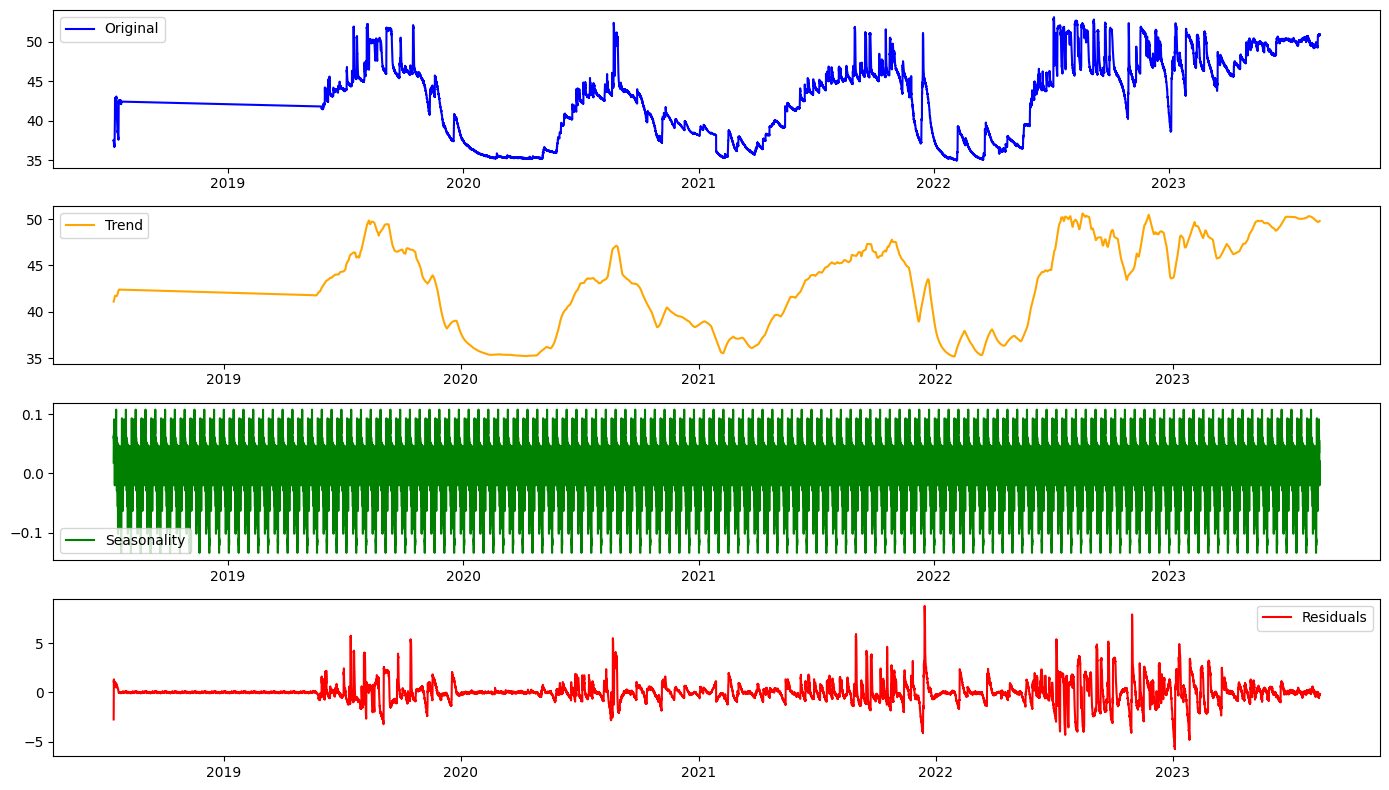

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data for soil moisture
decomposition = seasonal_decompose(temp_rain_soil['SoilMoist'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(temp_rain_soil['SoilMoist'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Print trend and seasonal components summary
print("Trend Summary:")
print(trend.dropna().describe())
print("\nSeasonality Summary:")
print(seasonal.describe())

Trend Summary:
count    44582.000000
mean        42.792707
std          4.451198
min         35.173066
25%         39.042357
50%         42.341003
75%         46.505849
max         50.617202
Name: trend, dtype: float64

Seasonality Summary:
count    44946.000000
mean         0.000045
std          0.051712
min         -0.134235
25%         -0.029431
50%          0.004866
75%          0.038748
max          0.107432
Name: seasonal, dtype: float64


C:\Users\Ying\AppData\Local\Temp\ipykernel_15232\3165699156.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = temp_rain_soil.resample('M').mean()


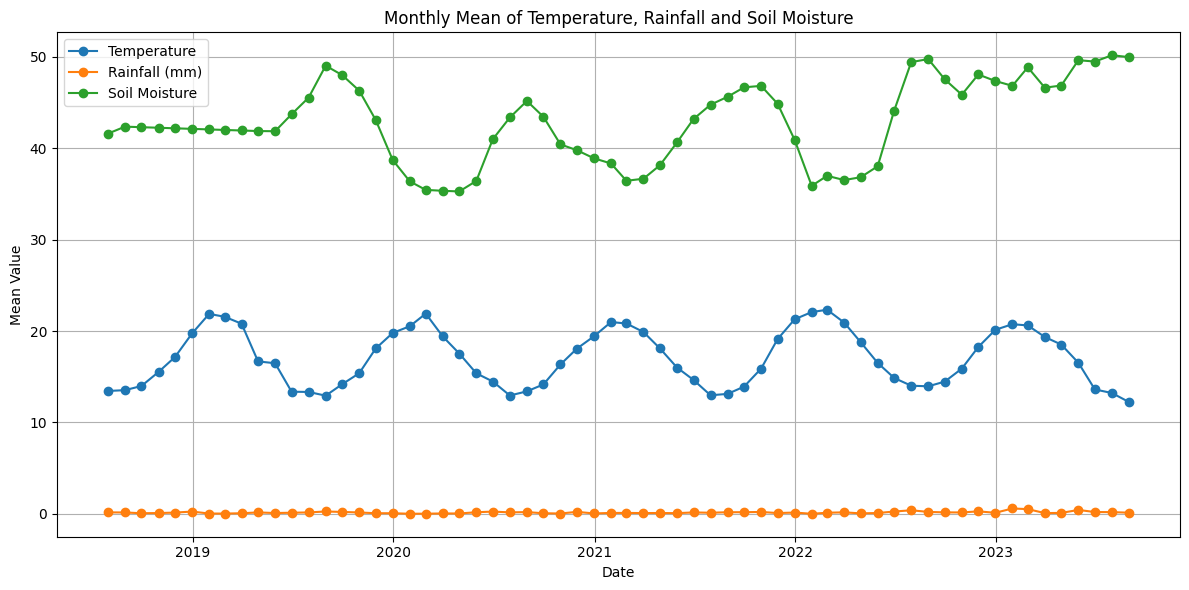

In [ ]:
monthly_means = temp_rain_soil.resample('M').mean()

# Plotting the monthly means
plt.figure(figsize=(12, 6))
plt.plot(monthly_means['Temp'], label='Temperature', marker='o')
plt.plot(monthly_means['Rain(mm)'], label='Rainfall (mm)', marker='o')
plt.plot(monthly_means['SoilMoist'], label='Soil Moisture', marker='o')
plt.title('Monthly Mean of Temperature, Rainfall and Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def create_lag_features(data, columns, lag_days):
    for col in columns:
        for lag in lag_days:
            data[f'lag_{col}_{lag}'] = data[col].shift(lag)
    data.dropna(inplace=True)
    return data

lags = [1, 2, 3, 7, 14, 20, 27]
temp_rain_soil_daily = create_lag_features(temp_rain_soil_daily, ['Temp', 'Rain(mm)'], lags)

# Check stationarity using ADF test
result = adfuller(temp_rain_soil_daily['SoilMoist'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.8261932624934436
p-value: 0.3675371748321017
Critical Values:
	1%: -3.433936263195097
	5%: -2.8631241351249
	10%: -2.5676133397235263


In [ ]:
soil_moist_diff = temp_rain_soil_daily['SoilMoist'].diff().diff().dropna()


In [ ]:
result_diff = adfuller(soil_moist_diff)
print('ADF Statistic (Doubly Differenced):', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

ADF Statistic (Doubly Differenced): -16.994412196387344
p-value: 8.821043139855857e-30
Critical Values:
	1%: -3.4339500836471712
	5%: -2.8631302362582534
	10%: -2.567616588375528


In [ ]:
# Feature selection and engineering
def create_lagged_features(df, lags):
    for lag in lags:
        df[f'SoilMoist_lag{lag}'] = df['SoilMoist'].shift(lag)
        df[f'Temp_lag{lag}'] = df['Temp'].shift(lag)
        df[f'Rain_lag{lag}'] = df['Rain(mm)'].shift(lag)
    return df

In [ ]:
lags = 7
df_lagged = create_lagged_features(temp_rain_soil_daily, lags)
df_lagged.dropna(inplace=True)


split_index = int(len(temp_rain_soil_daily) * 0.7)
train_data_soil = temp_rain_soil_daily['SoilMoist'][:split_index]
test_data_soil = temp_rain_soil_daily['SoilMoist'][split_index:]

print(f"Length of training data: {len(train_data_soil)}")
print(f"Length of testing data: {len(test_data_soil)}")

Length of training data: 1254
Length of testing data: 538


In [ ]:
train_data_soil.tail()

Timestamp (UTC+12:00)
2022-02-27    36.119958
2022-02-28    36.025521
2022-03-01    35.943698
2022-03-02    35.852219
2022-03-03    35.773104
Freq: D, Name: SoilMoist, dtype: float64

In [ ]:
# Fit the ARIMA model
p, d, q = 1, 1, 1
model_soil_moist = ARIMA(train_data_soil, order=(p, d, q))
model_fit_soil_moist = model_soil_moist.fit()
print(model_fit_soil_moist.summary())


                               SARIMAX Results                                
Dep. Variable:              SoilMoist   No. Observations:                 1254
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1311.252
Date:                Tue, 25 Jun 2024   AIC                           2628.505
Time:                        02:44:41   BIC                           2643.905
Sample:                    09-27-2018   HQIC                          2634.294
                         - 03-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4880      0.084     -5.840      0.000      -0.652      -0.324
ma.L1          0.5960      0.082      7.278      0.000       0.436       0.757
sigma2         0.4748      0.006     86.070      0.0

In [ ]:
forecast_steps = 14
forecast = model_fit_soil_moist.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=temp_rain_soil_daily.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
print(forecast_df.head(100))


           Forecast
2023-08-24      NaN
2023-08-25      NaN
2023-08-26      NaN
2023-08-27      NaN
2023-08-28      NaN
2023-08-29      NaN
2023-08-30      NaN
2023-08-31      NaN
2023-09-01      NaN
2023-09-02      NaN
2023-09-03      NaN
2023-09-04      NaN
2023-09-05      NaN
2023-09-06      NaN


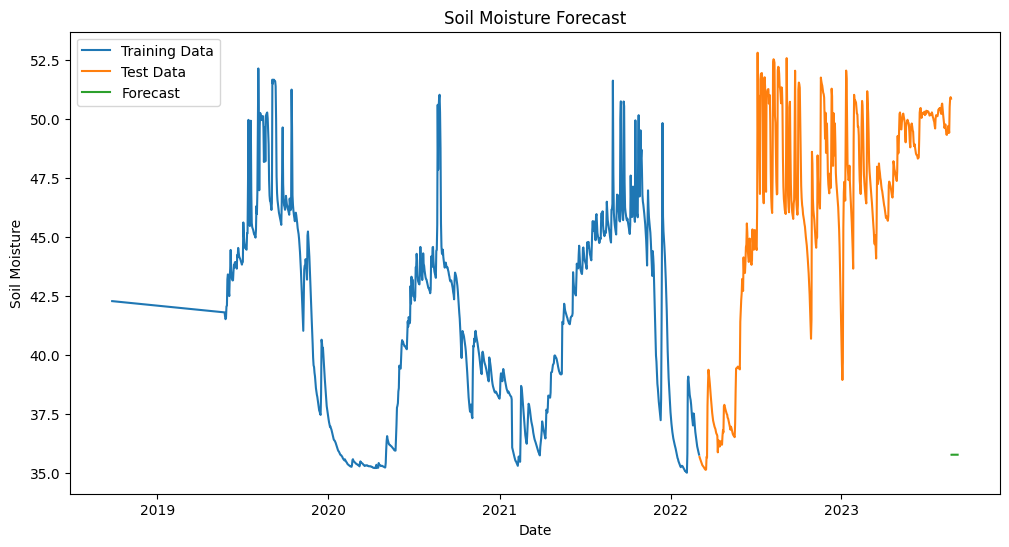

Mean Squared Error (MSE): 0.2016627539306907


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_soil.index, train_data_soil, label='Training Data')
plt.plot(test_data_soil.index, test_data_soil, label='Test Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.title('Soil Moisture Forecast')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()
mse = mean_squared_error(test_data_soil[:forecast_steps], forecast[:forecast_steps])
print(f'Mean Squared Error (MSE): {mse}')

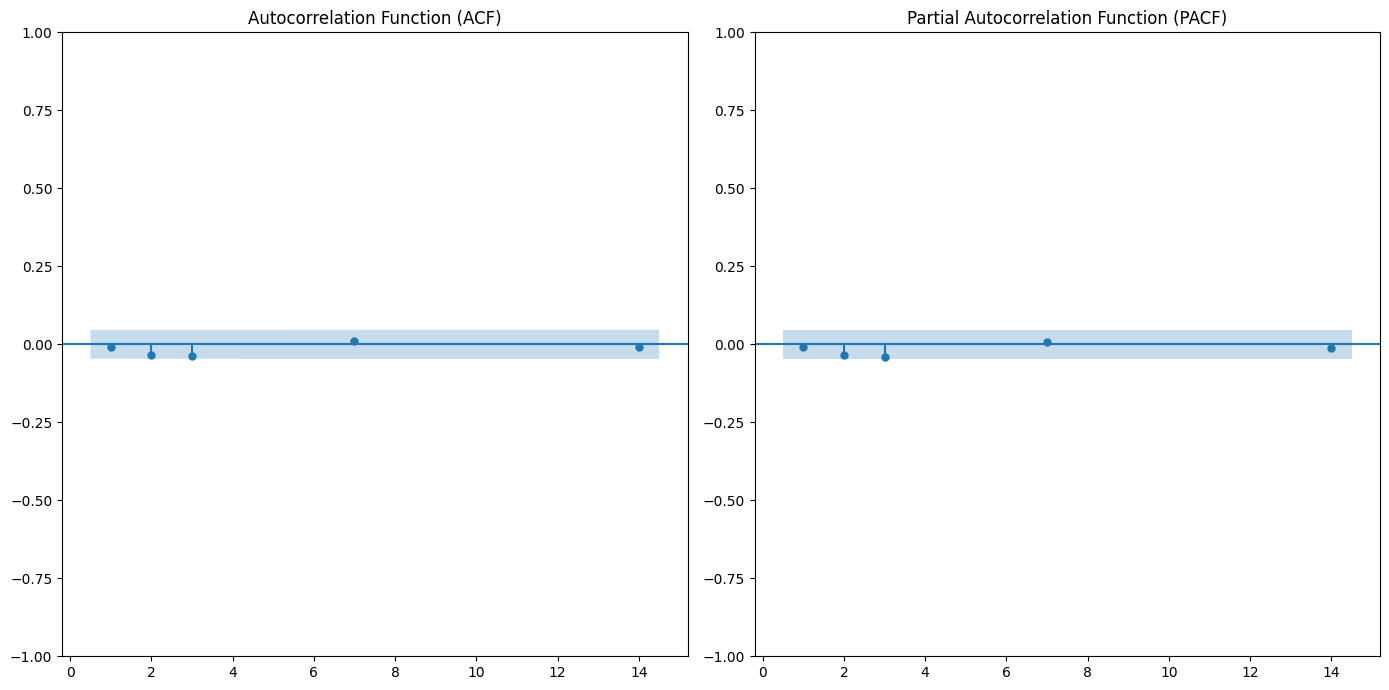

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
plt.figure(figsize=(14, 7))

# ACF
plt.subplot(121)
plot_acf(residuals, lags=lags, alpha=0.05, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(122)
plot_pacf(residuals, lags=lags, alpha=0.05, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()